In [1]:
# Python imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

# Pipelines
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 4 models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Splitting, scoring, tuning
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import GridSearchCV #not used now
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score,log_loss
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Datová sada - California Weather and Fire Prediction Dataset (1984-2025)
Pro účely analýzy jsem použil dataset s názvem „CA_Weather_Fire_Dataset_1984-2025.csv“.
Jedná se o datovou sadu kombinující data o počasí (NOAA) a záznamy o požárech (CAL FIRE). 
Data jsou veřejně dostupná: [odkaz na dataset](https://scholars.georgiasouthern.edu/en/datasets/california-weather-and-fire-prediction-dataset-19842025-with-engi).
V souboru jsou denní záznamy z Kalifornie od 1. ledna 1984 až do 12. ledna 2025. Celkem 14 990 záznamů. 

Seznam sloupců v datové sadě:

- **DATE**: Datum pozorování (YYYY-MM-DD)
- **PRECIPITATION**: Denní úhrn srážek v palcích
- **MAX_TEMP**: Maximální denní teplota ve °F
- **MIN_TEMP**: Minimální denní teplota ve °F
- **AVG_WIND_SPEED**: Průměrná denní rychlost větru v mph
- **FIRE_START_DAY**: Binární příznak (True/False), zda v daný den začal požár
- **YEAR**: Rok
- **TEMP_RANGE**: MAX_TEMP - MIN_TEMP
- **WIND_TEMP_RATIO**: AVG_WIND_SPEED / MAX_TEMP
- **MONTH**: Kalendářní měsíc (1–12)
- **SEASON**: Roční období (Winter, Spring, Summer, Fall)
- **LAGGED_PRECIPITATION**: Odvozeno (7denní kumulovaná srážková hodnota)
- **LAGGED_AVG_WIND_SPEED**: Odvozeno (7denní průměrná rychlost větru)
- **DAY_OF_YEAR**: Pořadové číslo dne v roce (1–366)

#### Načtení dat z csv a základní analýza

In [2]:
df = pd.read_csv('CA_Weather_Fire_Dataset_1984-2025.csv')  # Načtení dat do dataframu
df['DATE'] = pd.to_datetime(df['DATE'])  # Převedení na datetime
df['SEASON'] = df['DATE'].dt.month % 12 // 3 + 1  # Převedení na numerické hodnoty
df = df[df['YEAR'] < 2024]

#### Korelační heatmapa

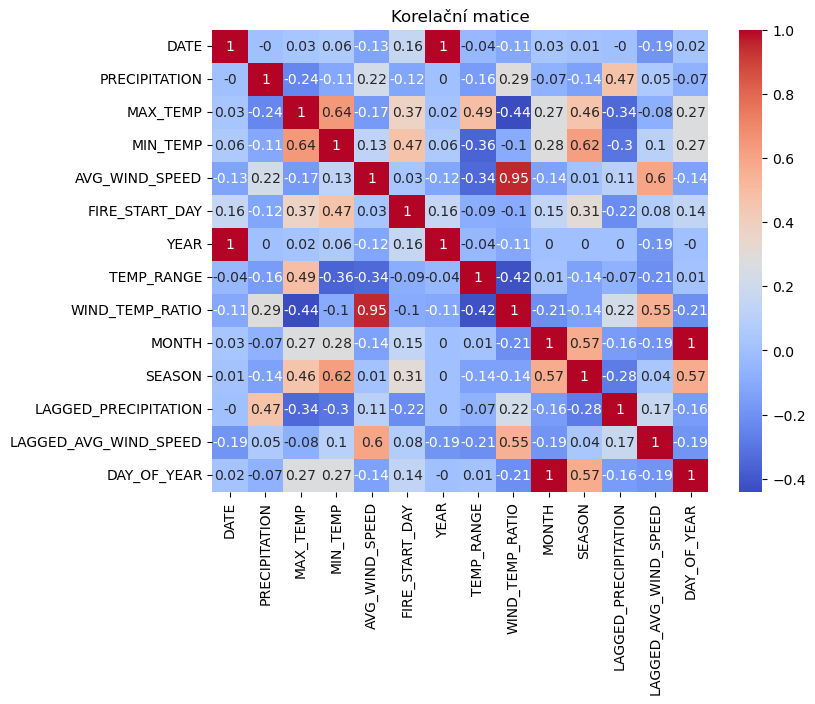

In [3]:
def plot_correlation_heatmap(df):
    # Korelační heatmapa
    plt.figure(figsize=(8, 6))
    corr = df.corr().round(2)
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Korelační matice')
    plt.show()

plot_correlation_heatmap(df)

Z heatmapy je vidět, že přítomnost požárů vyjádřená proměnné FIRE_START_DAY koreluje s teplotou a ročním obdobím. Negativní korelace je pak s přítomností srážek v proměnné LAGGED PRECIPITATION.

#### Vztah vzniku požárů na maximální teplotě a dni v roce

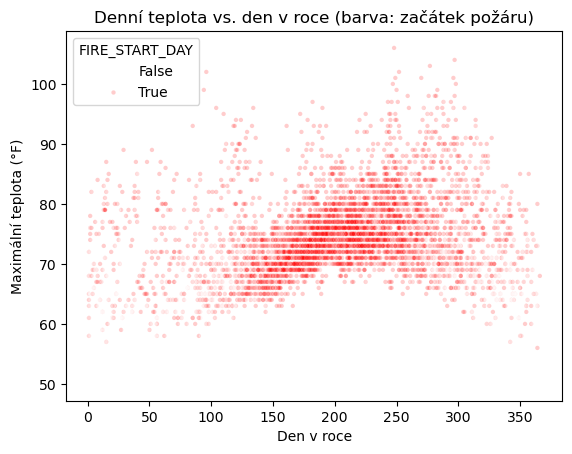

In [4]:
sns.scatterplot(data=df, x='DAY_OF_YEAR', y='MAX_TEMP', hue='FIRE_START_DAY', palette={True: 'red', False: 'white'}, alpha=0.2, s=10)
plt.title('Denní teplota vs. den v roce (barva: začátek požáru)')
plt.xlabel('Den v roce')
plt.ylabel('Maximální teplota (°F)')
plt.show()

### Časové řady počtu výskytů požárů, teploty a srážek

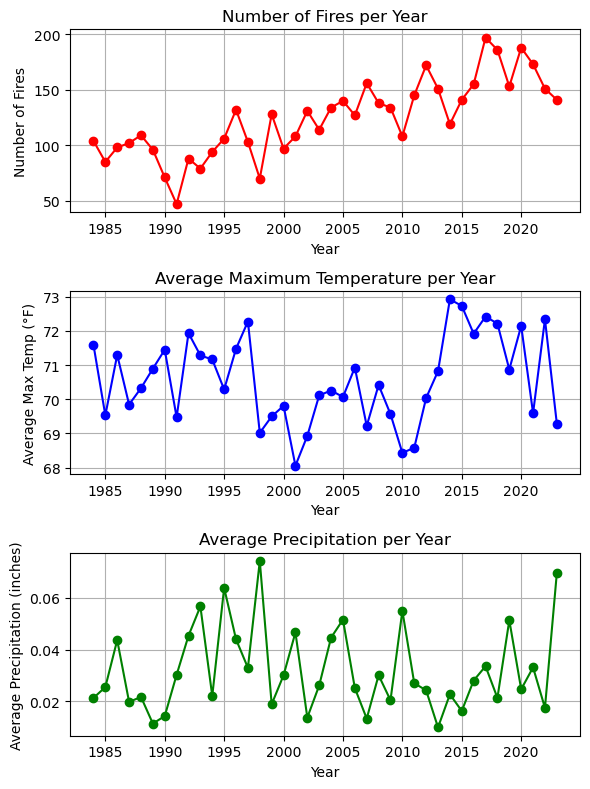

In [5]:
# Group data by year for fires and temperature
fires_per_year = df.groupby('YEAR')['FIRE_START_DAY'].sum()
avg_temp_per_year = df.groupby('YEAR')['MAX_TEMP'].mean()
avg_precip_per_year = df.groupby('YEAR')['PRECIPITATION'].mean()

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot number of fires per year
ax1.plot(fires_per_year.index, fires_per_year.values, marker='o', color='red')
ax1.set_title('Number of Fires per Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Fires')
ax1.grid(True)

# Plot average temperature per year
ax2.plot(avg_temp_per_year.index, avg_temp_per_year.values, marker='o', color='blue')
ax2.set_title('Average Maximum Temperature per Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Max Temp (°F)')
ax2.grid(True)

# Plot average precipitation per year
ax3.plot(avg_precip_per_year.index, avg_precip_per_year.values, marker='o', color='green')
ax3.set_title('Average Precipitation per Year')
ax3.set_xlabel('Year')
ax3.set_ylabel('Average Precipitation (inches)')
ax3.grid(True)

plt.tight_layout()
plt.show()

### Prepare dataset

In [6]:
# Create cyclic features for day of year
day = df['DATE'].dt.dayofyear
df['day_sin'] = np.sin(2 * np.pi * day / 365)
df['day_cos'] = np.cos(2 * np.pi * day / 365)
df_model = df.dropna().sort_values('DATE').reset_index(drop=True)


### VIF

In [7]:
# Test VIF for colinearity
def calculate_vif(dataframe, exclude_columns=None):
    """
    Calculate Variance Inflation Factor (VIF) for numeric columns in a DataFrame.
    """
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_columns:
        numeric_cols = [col for col in numeric_cols if col not in exclude_columns]
    df_vif = dataframe[numeric_cols].dropna()
    vif_data = pd.DataFrame({
        "Variable": df_vif.columns,
        "VIF": [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    })
    return vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

In [8]:
# Initial VIF calculation
exclude_columns_full = ['FIRE_START_DAY', 'DATE']
vif_result = calculate_vif(df_model, exclude_columns=exclude_columns_full)
print("VIF Analysis: before removing high VIF columns")
print(vif_result)
print("---")
print("VIF Analysis: after removing high VIF columns")
# Remove high VIF columns iteratively
exclude_columns = ['FIRE_START_DAY', 'DATE', 'MIN_TEMP', 'DAY_OF_YEAR', 'WIND_TEMP_RATIO', 'MONTH', 'YEAR', 'SEASON', 'TEMP_RANGE', 'LAGGED_AVG_WIND_SPEED']
vif_result = calculate_vif(df, exclude_columns=exclude_columns)
print(vif_result)

c:\Users\esiff\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Analysis: before removing high VIF columns
                 Variable          VIF
0                MAX_TEMP          inf
1                MIN_TEMP          inf
2              TEMP_RANGE          inf
3          AVG_WIND_SPEED  1113.909246
4                    YEAR  1013.315532
5         WIND_TEMP_RATIO   978.028888
6                   MONTH   661.459700
7             DAY_OF_YEAR   578.237709
8   LAGGED_AVG_WIND_SPEED    71.112195
9                  SEASON    17.828567
10                day_sin     4.713895
11                day_cos     4.356023
12   LAGGED_PRECIPITATION     1.881356
13          PRECIPITATION     1.490688
---
VIF Analysis: after removing high VIF columns
               Variable        VIF
0        AVG_WIND_SPEED  13.371746
1              MAX_TEMP  12.633336
2  LAGGED_PRECIPITATION   1.603841
3         PRECIPITATION   1.395610
4               day_cos   1.187150
5               day_sin   1.117751


### Chronological Split

In [9]:
y = df_model['FIRE_START_DAY']
X = df_model.drop(columns=exclude_columns)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

### Pipelines

In [10]:
# Pipeline for Logistic Regression
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True))
])

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier())
])

pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier())
])

ms = {
    'logreg': pipe_logreg,
    'svc': pipe_svc,
    'rf': pipe_rf,
    'gb': pipe_gb
}

### Test

In [12]:
# Compare the models with PCA using cross-validation
results = []
for name, pipe in ms.items():
    cv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1')
    print(f"{name} CV F1 scores: ")
    print(cv_scores, "\n", f"Mean: {cv_scores.mean()}, Std: {cv_scores.std()}\n")

    # Fit the model on the full training set and evaluate on the test set
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Store metrics
    metrics = {
        'model': name,
        'cv_roc_auc_mean': cv_scores.mean(),
        'cv_roc_auc_std': cv_scores.std(),
        'test_roc_auc': roc_auc_score(y_test, y_proba),
        'test_pr_auc': average_precision_score(y_test, y_proba),
        'test_f1': f1_score(y_test, y_pred),
        'test_log_loss': log_loss(y_test, y_proba)
    }
    results.append(metrics)
    print(f"{name} | CV ROC AUC: {metrics['cv_roc_auc_mean']:.3f} ± {metrics['cv_roc_auc_std']:.3f} | Test ROC AUC: {metrics['test_roc_auc']:.3f}")

# Display results in a DataFrame
results_df = pd.DataFrame(results).sort_values('test_roc_auc', ascending=False)
results_df

logreg CV F1 scores: 
[0.54365079 0.55625    0.6135217  0.64831804 0.64525765] 
 Mean: 0.6013996373375916, Std: 0.043920895869308606

logreg | CV ROC AUC: 0.601 ± 0.044 | Test ROC AUC: 0.853
svc CV F1 scores: 
[0.50739958 0.52744887 0.59067358 0.63931889 0.63700234] 
 Mean: 0.5803686498836532, Std: 0.054614440459454926

svc CV F1 scores: 
[0.50739958 0.52744887 0.59067358 0.63931889 0.63700234] 
 Mean: 0.5803686498836532, Std: 0.054614440459454926

svc | CV ROC AUC: 0.580 ± 0.055 | Test ROC AUC: 0.795
svc | CV ROC AUC: 0.580 ± 0.055 | Test ROC AUC: 0.795
rf CV F1 scores: 
[0.46835443 0.51410658 0.54268293 0.5974026  0.58796296] 
 Mean: 0.5421019001293351, Std: 0.047716179366681336

rf CV F1 scores: 
[0.46835443 0.51410658 0.54268293 0.5974026  0.58796296] 
 Mean: 0.5421019001293351, Std: 0.047716179366681336

rf | CV ROC AUC: 0.542 ± 0.048 | Test ROC AUC: 0.818
rf | CV ROC AUC: 0.542 ± 0.048 | Test ROC AUC: 0.818
gb CV F1 scores: 
[0.5030426  0.54752066 0.64745437 0.66910688 0.62896979

model  cv_roc_auc_mean  cv_roc_auc_std  test_roc_auc  test_pr_auc  \
3      gb         0.599219        0.063275      0.855509     0.817508   
0  logreg         0.601400        0.043921      0.853365     0.816304   
2      rf         0.542102        0.047716      0.817935     0.772598   
1     svc         0.580369        0.054614      0.794763     0.786535   

    test_f1  test_log_loss  
3  0.647541       0.540569  
0  0.678161       0.543270  
2  0.615243       0.721105  
1  0.618303       0.592046

#### Prediction

In [18]:
#dummy data, intended to be replaced with real weather forecast data for prediction
#----------------------Inputs---------------------------------------------
# Input features for prediction
day=150 #day of year for cyclic features
precipitation=0.1 #[mm]
max_temp=85 #[°F]
avg_wind_speed=5 #[mph]
lagged_precipitation=5 #[mm sum of last 7 days]
# Chosen model is logistic regression as default, due to highest f1 score
model = 'logreg' #choose model from 'logreg', 'svc', 'rf', 'gb'
#---------------------------------------------------------------------------
X_new = pd.DataFrame([{
    'PRECIPITATION': precipitation,
    'MAX_TEMP': max_temp,
    'AVG_WIND_SPEED': avg_wind_speed,
    'LAGGED_PRECIPITATION': lagged_precipitation,
    'day_sin': np.sin(2 * np.pi * day / 365),
    'day_cos': np.cos(2 * np.pi * day / 365),
}], columns=X.columns)

# Use the fitted logistic regression pipeline from models
logreg = ms[model]
p_fire = logreg.predict_proba(X_new)[0, 1]
print(f"Pravděpodobnost požáru: {p_fire:.2%}")

Pravděpodobnost požáru: 0.62%
